In [1]:
from typing import List

import pandas as pd
from pandas import DataFrame

RANDOM_STATE = 111

dataframe = pd.read_csv("data.csv", header=0)
dataframe.loc[dataframe["y"] < 50, "y"] = 1
dataframe.loc[dataframe["y"] >= 50, "y"] = 0

In [2]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler


def get_keys(df: DataFrame) -> List[str]:
    result = []

    for col in df.columns:
        result.append(col)

    result.remove("y")
    return result


def get_train_val(x_data, y_data):
    return train_test_split(x_data, y_data, test_size=0.2, random_state=RANDOM_STATE, stratify=y_data)


def get_train_val_split(x_data, y_data):
    return train_test_split(x_data, y_data, test_size=0.25, random_state=RANDOM_STATE, stratify=y_data)


def remove_outliers(x_data, y_data):
    the_pca = PCA(n_components=3, random_state=RANDOM_STATE)
    all_pca = the_pca.fit_transform(x_data)

    mask = []

    for idx, unit in enumerate(all_pca):
        x = unit[0]
        y = unit[1]
        z = unit[2]

        if x > 500:
            continue
        elif y > 100:
            continue
        elif z > 40:
            continue

        mask.append(idx)

    return x_data.loc[mask, :], y_data.loc[mask]


keys = get_keys(dataframe)
X_all = dataframe[keys]
y_all = dataframe["y"]
X_all, y_all = remove_outliers(X_all, y_all)
X_train, _, y_train, _ = get_train_val(X_all, y_all)
X_train, X_val, y_train, y_val = get_train_val_split(X_train, y_train)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

smote = SMOTE(random_state=RANDOM_STATE)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [3]:
import matplotlib.pyplot as plt


def plot_dataset(x_data, y_data):
    the_pca = PCA(n_components=3)
    all_pca = the_pca.fit_transform(x_data)
    all_label = y_data
    colors = []

    for label in all_label:
        if label == 1:
            colors.append("red")
        else:
            colors.append("blue")

    x_plt = []
    y_plt = []
    z_plt = []

    for unit in all_pca:
        x_plt.append(unit[0])
        y_plt.append(unit[1])
        z_plt.append(unit[2])

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(x_plt, y_plt, z_plt, c=colors)
    plt.gca().view_init(20, -70)
    plt.show()

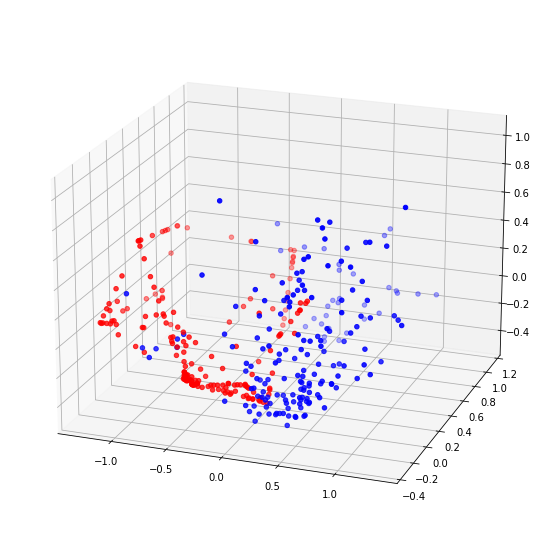

In [4]:
plot_dataset(X_train, y_train)

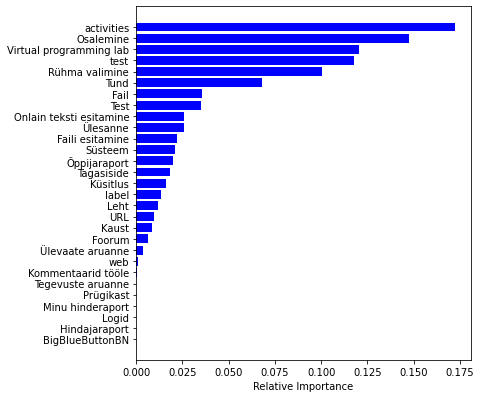

In [5]:
from typing import List

import numpy as np
from sklearn.ensemble import RandomForestClassifier


def plot_feature_importances() -> List[str]:
    y = []
    results = []
    i = 0
    feature_names = dataframe.columns[:-1]

    forest = RandomForestClassifier(class_weight={1: 10}, random_state=RANDOM_STATE)
    forest.fit(X_train, y_train)

    for imt in forest.feature_importances_:
        imt = round(imt,4)
        results.append((feature_names[i], imt))
        i = i + 1

    results.sort(key=lambda importance: importance[1])
    results.reverse()

    importances = forest.feature_importances_
    indices = np.argsort(importances)
    plt.figure(figsize=(6, 6.5))
    plt.barh(range(len(indices)), importances[indices], color="b", align="center")

    for s in results:
        y.append(s[0])

    y.reverse()
    plt.yticks(np.arange(len(y)), y)
    plt.xlabel("Relative Importance")
    plt.show()

    return y

features = plot_feature_importances()
features.reverse()

In [6]:
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold
from sklearn.svm import SVC

scoring = ["accuracy", "recall", "roc_auc"]

def get_best_feature():
    count_dict = {}

    for count in range(1, len(features) + 1):
        score = get_roc_auc_score(count)
        count_dict[count] = score

    return count_dict


def get_roc_auc_score(count: int):
    x_all_f = dataframe[keys]
    y_all_f = dataframe["y"]
    x_all_f, y_all_f = remove_outliers(x_all_f, y_all_f)
    x_train_f, _, y_train_f, _ = get_train_val(x_all_f, y_all_f)
    selected_feature_f = features[:count]
    x_train_f = x_train_f[selected_feature_f]

    kf_f = RepeatedStratifiedKFold(n_splits=4, n_repeats=20, random_state=RANDOM_STATE)
    pipeline_f = make_pipeline(
            MinMaxScaler(),    # noqa
            SMOTE(random_state=RANDOM_STATE),    # noqa
            SVC(random_state=RANDOM_STATE)    # noqa
    )

    cv_results_f = cross_validate(pipeline_f, x_train_f, y_train_f, cv=kf_f, scoring=scoring)
    print(f"{count} CV Accuracy: {cv_results_f['test_accuracy'].mean() * 100:.2f}%")
    print(f"{count} CV Recall: {cv_results_f['test_recall'].mean() * 100:.2f}%")
    print(f"{count} CV ROC-AUC: {cv_results_f['test_roc_auc'].mean():.2f}")

    return cv_results_f["test_roc_auc"].mean()

In [7]:
all_count_dict = get_best_feature()

1 CV Accuracy: 79.83%
1 CV Recall: 83.83%
1 CV ROC-AUC: 0.88
2 CV Accuracy: 80.97%
2 CV Recall: 73.92%
2 CV ROC-AUC: 0.88
3 CV Accuracy: 83.22%
3 CV Recall: 74.04%
3 CV ROC-AUC: 0.88
4 CV Accuracy: 81.79%
4 CV Recall: 70.17%
4 CV ROC-AUC: 0.86
5 CV Accuracy: 82.90%
5 CV Recall: 72.00%
5 CV ROC-AUC: 0.89
6 CV Accuracy: 83.93%
6 CV Recall: 71.37%
6 CV ROC-AUC: 0.89
7 CV Accuracy: 84.37%
7 CV Recall: 74.88%
7 CV ROC-AUC: 0.90
8 CV Accuracy: 85.04%
8 CV Recall: 72.17%
8 CV ROC-AUC: 0.90
9 CV Accuracy: 89.08%
9 CV Recall: 73.83%
9 CV ROC-AUC: 0.93
10 CV Accuracy: 88.98%
10 CV Recall: 70.96%
10 CV ROC-AUC: 0.93
11 CV Accuracy: 89.28%
11 CV Recall: 70.67%
11 CV ROC-AUC: 0.92
12 CV Accuracy: 89.17%
12 CV Recall: 69.58%
12 CV ROC-AUC: 0.92
13 CV Accuracy: 89.17%
13 CV Recall: 70.29%
13 CV ROC-AUC: 0.92
14 CV Accuracy: 88.17%
14 CV Recall: 67.17%
14 CV ROC-AUC: 0.91
15 CV Accuracy: 87.95%
15 CV Recall: 65.92%
15 CV ROC-AUC: 0.91
16 CV Accuracy: 89.24%
16 CV Recall: 62.08%
16 CV ROC-AUC: 0.90
17 

In [8]:
best_count = max(all_count_dict, key=all_count_dict.get)
print(f"Best score {all_count_dict[best_count]:.4f}")
print(f"Best count {best_count}")

Best score 0.9303
Best count 10


In [9]:
from sklearn.model_selection import GridSearchCV

X_all = dataframe[keys]
y_all = dataframe["y"]
X_all, y_all = remove_outliers(X_all, y_all)
X_train, _, y_train, _ = get_train_val(X_all, y_all)
selected_feature = features[:best_count]
X_train = X_train[selected_feature]

pipe = make_pipeline(
    MinMaxScaler(),    # noqa
    SMOTE(random_state=RANDOM_STATE),    # noqa
    SVC(random_state=RANDOM_STATE)    # noqa
)

class_weight_list = []

for weight in np.linspace(0.1, 2, 40):
    class_weight_list.append({1: weight})

param_grid = {
    "svc__C": np.logspace(-1, 7, 10),
    "svc__gamma": np.logspace(-7, -1, 10),
    "svc__class_weight": class_weight_list
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, scoring="roc_auc")
search.fit(X_train, y_train)

print(f"Best parameter score: {search.best_score_}")
print(search.best_params_)

Best parameter score: 0.9487836734693879
{'svc__C': 46.41588833612777, 'svc__class_weight': {1: 0.19743589743589746}, 'svc__gamma': 0.021544346900318822}


In [10]:
from sklearn.metrics import roc_auc_score

# Final test with the test dataset
X_all = dataframe[keys]
y_all = dataframe["y"]
X_all, y_all = remove_outliers(X_all, y_all)

X_train, X_test, y_train, y_test = get_train_val(X_all, y_all)

selected_feature = features[:best_count]
X_train = X_train[selected_feature]
X_test = X_test[selected_feature]

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

smote = SMOTE(random_state=RANDOM_STATE)
X_train, y_train = smote.fit_resample(X_train, y_train)

model = SVC(
    class_weight=search.best_params_["svc__class_weight"],
    C=search.best_params_["svc__C"],
    gamma=search.best_params_["svc__gamma"],
    random_state=RANDOM_STATE,
    probability=True
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Accuracy: {np.sum(y_pred == y_test) / len(y_test) * 100:.2f}%")
print(f"Recall rate: {(np.sum(y_pred == 1) / np.sum(y_test == 1)) * 100:.2f}%")
print(f"ROC-AUC: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.2f}")

Accuracy: 91.18%
Recall rate: 100.00%
ROC-AUC: 0.88
